In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import keras 
import datetime
import requests
import warnings
import keras

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-24 16:25:32.485406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [26]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['model', 'mae', 'mape', 'rsq'])

# Pre-processing

In [3]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)
df

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Belgium,location_Chile,location_Czechia,location_Estonia,location_France,location_Ireland,location_Israel,location_Italy,location_Malaysia,location_United States
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-08,316.0,315.0,0.0,27.111,27.025,0.000,0.000,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-15,1362.0,1046.0,9.0,116.850,89.740,4.547,22.564,NaN,18.960,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-22,4473.0,3111.0,140.0,383.753,266.903,27.969,142.503,NaN,128.604,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-29,12031.0,7558.0,602.0,1032.179,648.426,82.447,389.158,NaN,300.191,NaN,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10,103436829.0,NaN,1614.0,305763.910,NaN,7.168,58.512,NaN,70.395,NaN,...,0,0,0,0,0,0,0,0,0,1
2023-12-17,103436829.0,NaN,1450.0,305763.910,NaN,7.325,62.390,NaN,75.678,NaN,...,0,0,0,0,0,0,0,0,0,1
2023-12-24,103436829.0,NaN,1263.0,305763.910,NaN,8.546,68.988,NaN,89.101,NaN,...,0,0,0,0,0,0,0,0,0,1


In [4]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 
def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [5]:
df=process(df)
df=normalize(df)
df.shape

(20209, 68)

In [6]:
def make_series(data):
    series=[]
    for i in range(len(data)-14):
        subdf=data[i:i+14]
        series.append( (subdf.index[-1], subdf['new_deaths'].values[-1], subdf.drop('new_deaths', axis=1).values))
    return series
series=make_series(df)
print(series[0][0],series[0][1].shape,series[0][2].shape)
train_size = int(len(series) * 0.7)
train, test = series[0:train_size], series[train_size:]
#train=series[:-30]
#test=series[-30:]

2020-03-01 00:00:00 () (14, 67)


# Attempt 1

## Training

In [7]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =14

In [11]:
inputs = keras.layers.Input(shape=(14,67))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12800     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [12]:
x=np.array([x[2].reshape(14,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 67)
(14136,)
Epoch 1/100
442/442 [==============================] - 11s 14ms/step - loss: 1099.2166
Epoch 2/100
442/442 [==============================] - 6s 14ms/step - loss: 1084.9596
Epoch 3/100
442/442 [==============================] - 7s 16ms/step - loss: 1078.9995
Epoch 4/100
442/442 [==============================] - 7s 16ms/step - loss: 1075.8961
Epoch 5/100
442/442 [==============================] - 7s 16ms/step - loss: 1073.9071
Epoch 6/100
442/442 [==============================] - 7s 16ms/step - loss: 1072.5454
Epoch 7/100
442/442 [==============================] - 8s 19ms/step - loss: 1072.0015
Epoch 8/100
442/442 [==============================] - 8s 18ms/step - loss: 1071.2925
Epoch 9/100
442/442 [==============================] - 7s 17ms/step - loss: 1070.7952
Epoch 10/100
442/442 [==============================] - 7s 16ms/step - loss: 1070.6755
Epoch 11/100
442/442 [==============================] - 7s 17ms/step - loss: 1070.1135
Epoch 12/100
442/442 [====

## Testing

In [13]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_pred.head()

442/442 [==============================] - 3s 5ms/step


,yhat
2020-03-01,0.807554
2020-03-01,-0.964046
2020-03-01,2.219581
2020-03-01,0.820602
2020-03-01,-1.922895


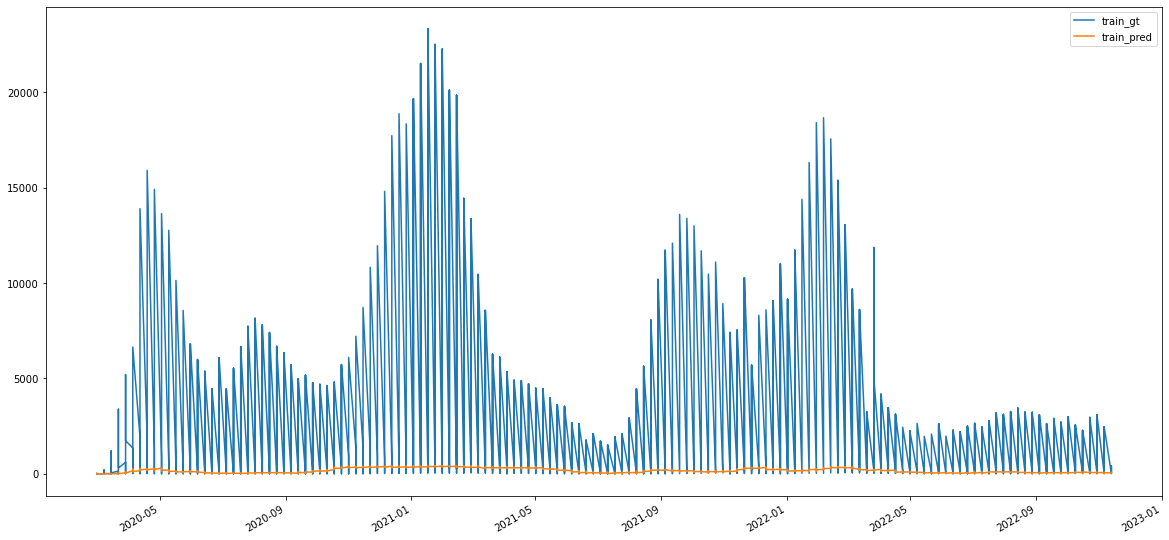

In [14]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 6ms/step


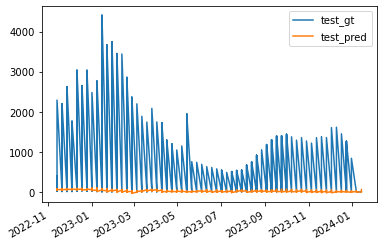

In [16]:
test_pred=model.predict(np.array([x[2].reshape(14, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [27]:
mae = mean_absolute_error(test_gt, test_pred)
mape = np.mean(np.abs((test_gt['y'] - test_pred['yhat']) / (test_gt['y'] + 1))) * 100
r2 = r2_score(test_gt, test_pred)
new_row = {'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 2

## Training

In [29]:
learning_rate = 0.001
batch_size = 16
epochs = 50
sequence_length =14

In [32]:
inputs = keras.layers.Input(shape=(14,67))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12800     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [33]:
x=np.array([x[2].reshape(14,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 67)
(14136,)
Epoch 1/50
884/884 [==============================] - 15s 13ms/step - loss: 1113.8459
Epoch 2/50
884/884 [==============================] - 11s 13ms/step - loss: 1101.9135
Epoch 3/50
884/884 [==============================] - 13s 15ms/step - loss: 1095.9900
Epoch 4/50
884/884 [==============================] - 10s 12ms/step - loss: 1092.2490
Epoch 5/50
884/884 [==============================] - 14s 15ms/step - loss: 1089.0626
Epoch 6/50
884/884 [==============================] - 18s 21ms/step - loss: 1086.3774
Epoch 7/50
884/884 [==============================] - 20s 23ms/step - loss: 1084.0164
Epoch 8/50
884/884 [==============================] - 16s 18ms/step - loss: 1081.9944
Epoch 9/50
884/884 [==============================] - 18s 20ms/step - loss: 1080.3865
Epoch 10/50
884/884 [==============================] - 14s 16ms/step - loss: 1078.8904
Epoch 11/50
884/884 [==============================] - 14s 16ms/step - loss: 1077.5624
Epoch 12/50
884/884 [======

## Testing

In [34]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 2s 3ms/step


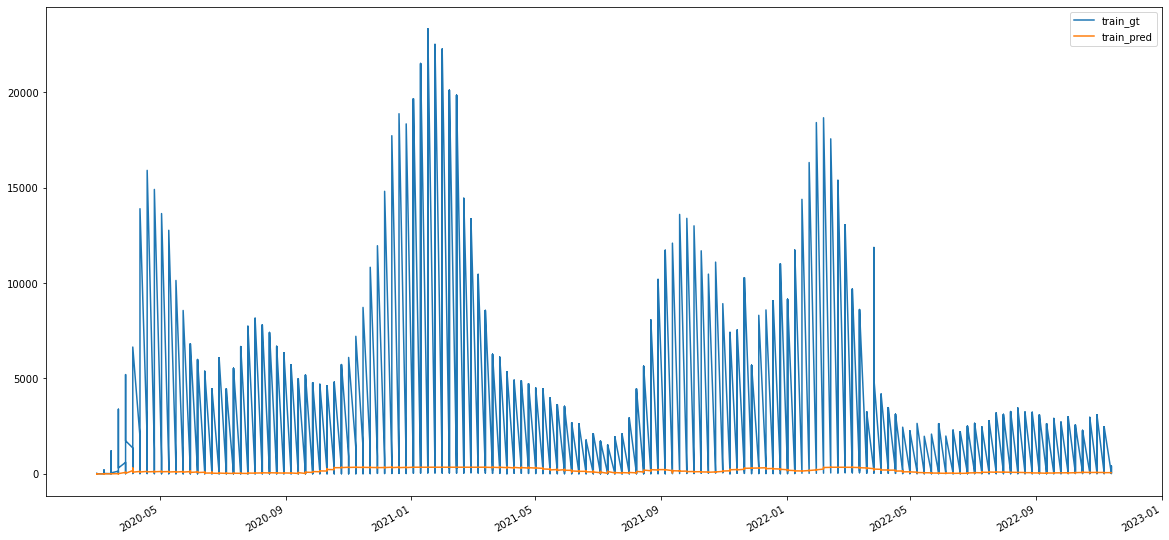

In [35]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 5ms/step


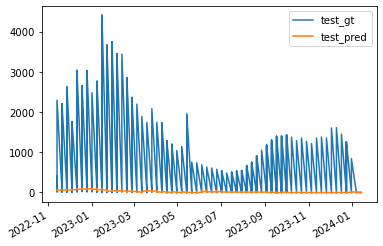

In [37]:
test_pred=model.predict(np.array([x[2].reshape(14, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [38]:
mae = mean_absolute_error(test_gt, test_pred)
mape = np.mean(np.abs((test_gt['y'] - test_pred['yhat']) / (test_gt['y'] + 1))) * 100
r2 = r2_score(test_gt, test_pred)
new_row = {'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 3

## Training

In [40]:
learning_rate = 0.001
batch_size = 16
epochs = 50
sequence_length =14

In [41]:
inputs = keras.layers.Input(shape=(14,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(32)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 14, 64)            33792     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [42]:
x=np.array([x[2].reshape(14,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 67)
(14136,)
Epoch 1/50
884/884 [==============================] - 42s 34ms/step - loss: 1113.6926
Epoch 2/50
884/884 [==============================] - 20s 23ms/step - loss: 1102.0894
Epoch 3/50
884/884 [==============================] - 22s 25ms/step - loss: 1096.1401
Epoch 4/50
884/884 [==============================] - 21s 24ms/step - loss: 1093.2653
Epoch 5/50
884/884 [==============================] - 21s 24ms/step - loss: 1091.4210
Epoch 6/50
884/884 [==============================] - 21s 24ms/step - loss: 1088.3099
Epoch 7/50
884/884 [==============================] - 21s 24ms/step - loss: 1085.4091
Epoch 8/50
884/884 [==============================] - 21s 24ms/step - loss: 1083.1168
Epoch 9/50
884/884 [==============================] - 21s 24ms/step - loss: 1081.2998
Epoch 10/50
884/884 [==============================] - 23s 26ms/step - loss: 1080.0797
Epoch 11/50
884/884 [==============================] - 23s 26ms/step - loss: 1078.7974
Epoch 12/50
884/884 [======

## Testing

In [43]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 4s 5ms/step


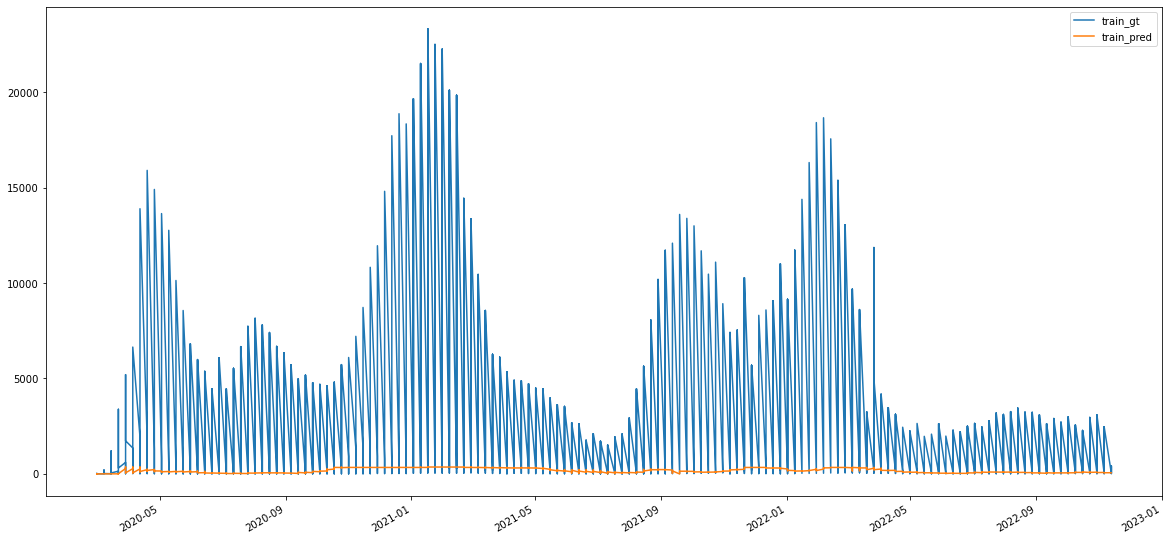

In [44]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 6ms/step


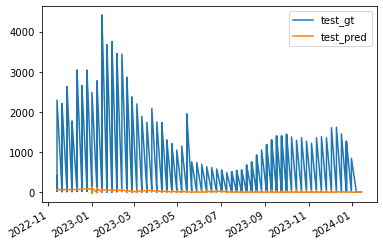

In [46]:
test_pred=model.predict(np.array([x[2].reshape(14, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [47]:
mae = mean_absolute_error(test_gt, test_pred)
mape = np.mean(np.abs((test_gt['y'] - test_pred['yhat']) / (test_gt['y'] + 1))) * 100
r2 = r2_score(test_gt, test_pred)
new_row = {'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 4

## Training

In [48]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [49]:
learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
batch_size = 16
epochs = 50
sequence_length =14

In [50]:
inputs = keras.layers.Input(shape=(14,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14, 67)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            33792     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [51]:
x=np.array([x[2].reshape(14,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14136, 14, 67)
(14136,)
Epoch 1/50
884/884 [==============================] - 44s 39ms/step - loss: 1113.9941
Epoch 2/50
884/884 [==============================] - 39s 44ms/step - loss: 1102.4116
Epoch 3/50
884/884 [==============================] - 39s 44ms/step - loss: 1096.6077
Epoch 4/50
884/884 [==============================] - 39s 44ms/step - loss: 1093.0558
Epoch 5/50
884/884 [==============================] - 36s 41ms/step - loss: 1089.9017
Epoch 6/50
884/884 [==============================] - 43s 48ms/step - loss: 1087.1414
Epoch 7/50
884/884 [==============================] - 41s 46ms/step - loss: 1084.8501
Epoch 8/50
884/884 [==============================] - 41s 47ms/step - loss: 1082.8589
Epoch 9/50
884/884 [==============================] - 37s 41ms/step - loss: 1081.1256
Epoch 10/50
884/884 [==============================] - 37s 42ms/step - loss: 1079.5709
Epoch 11/50
884/884 [==============================] - 39s 44ms/step - loss: 1078.3099
Epoch 12/50
884/884 [======

KeyboardInterrupt: 

## Testing

In [24]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 5s 9ms/step


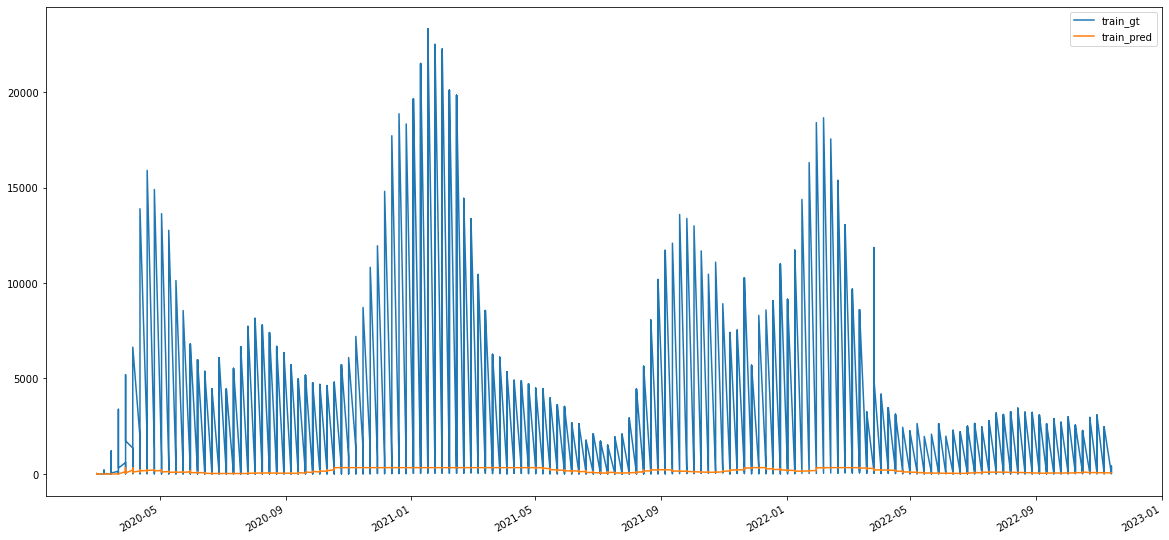

In [25]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 2s 10ms/step


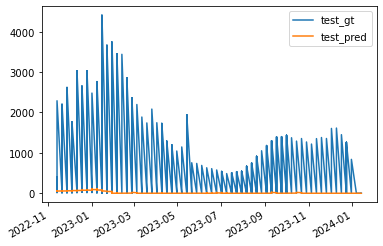

In [26]:
test_pred=model.predict(np.array([x[2].reshape(14, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [27]:
mae = mean_absolute_error(test_gt, test_pred)
mape = np.mean(np.abs((test_gt['y'] - test_pred['yhat']) / (test_gt['y'] + 1))) * 100
r2 = r2_score(test_gt, test_pred)
new_row = {'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

Test MAE:  214.5342908740575
Test MAPE:  1674961793944052.0
Test r-squared:  -0.11732013002742558


# Attempt 5

## Training

In [28]:
learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
batch_size = 16
epochs = 50
sequence_length =14

In [29]:
inputs = keras.layers.Input(shape=(14,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 57)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 14, 64)            31232     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43,681
Trainable params: 43,681
Non-trainable params: 0
_________________________________________________________________


In [30]:
x=np.array([x[2].reshape(14,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

(14136, 14, 57)
(14136,)
Epoch 1/50
707/707 [==============================] - 36s 40ms/step - loss: 1295.5869 - val_loss: 403.7201
Epoch 2/50
707/707 [==============================] - 33s 46ms/step - loss: 1284.7407 - val_loss: 402.3911
Epoch 3/50
707/707 [==============================] - 36s 50ms/step - loss: 1277.9810 - val_loss: 403.0869
Epoch 4/50
707/707 [==============================] - 39s 55ms/step - loss: 1273.6544 - val_loss: 402.5320
Epoch 5/50
707/707 [==============================] - 31s 45ms/step - loss: 1270.5983 - val_loss: 404.2830
Epoch 6/50
707/707 [==============================] - 30s 42ms/step - loss: 1268.4702 - val_loss: 405.2790
Epoch 7/50
707/707 [==============================] - 29s 42ms/step - loss: 1265.1125 - val_loss: 405.0868


## Testing

In [31]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 4s 7ms/step


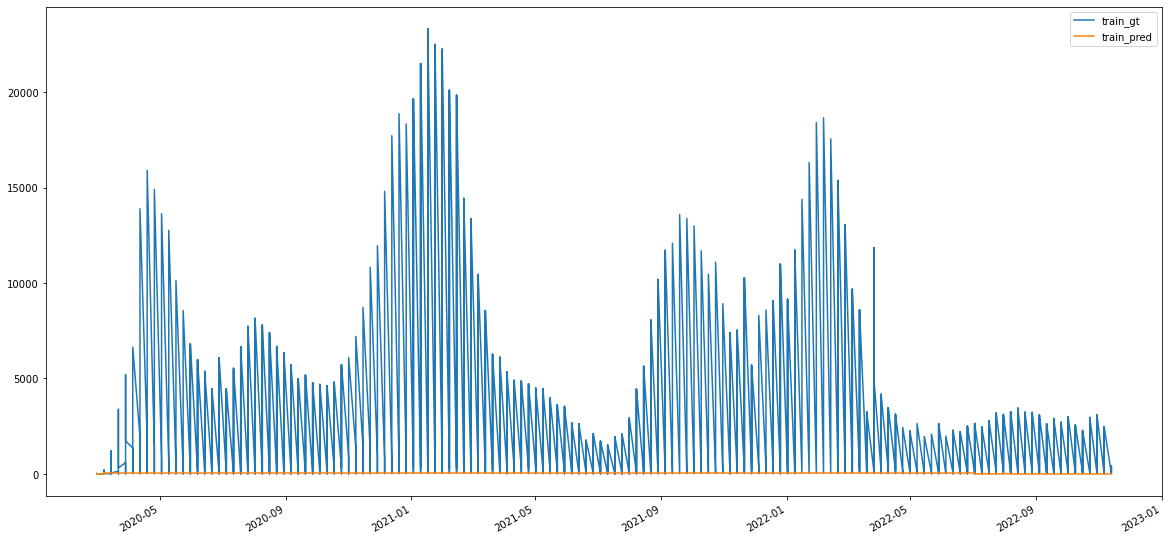

In [32]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 2s 11ms/step


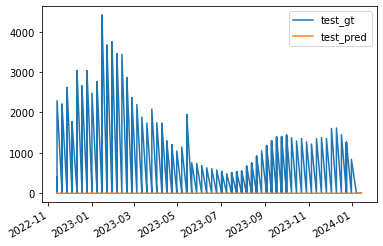

In [33]:
test_pred=model.predict(np.array([x[2].reshape(14, 57) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [34]:
mae = mean_absolute_error(test_gt, test_pred)
mape = np.mean(np.abs((test_gt['y'] - test_pred['yhat']) / (test_gt['y'] + 1))) * 100
r2 = r2_score(test_gt, test_pred)
new_row = {'model': '1', 'mae': mae, 'mape': mape, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

Test MAE:  221.0246795705392
Test MAPE:  353440966522151.8
Test r-squared:  -0.15053725962704223
